In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.fftpack import fft, ifft
import seaborn as sns 
from obspy.io.segy.segy import _read_segy
from las import LASReader
from tabulate import tabulate
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
tk1 = LASReader('tokal1-final.las', null_subs=np.nan)
print (tk1.curves.names)

['DEPTH', 'AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'ATCO90', 'BVW_2013', 'CALI', 'CGR', 'DTCO', 'DTSM', 'GR', 'HDMI', 'HDMX', 'K_TIXIER', 'MD', 'NPHI', 'PE', 'PHIE_2013', 'PHIT_2013', 'POTA', 'RHOB', 'SWSIMAN_2013', 'THOR', 'URAN', 'VSHALE_STIEBER']


In [3]:
print(tk1.curves.DEPTH)#Unidades de profundidad en metros.
print(tk1.curves.DTCO)#Unidades de la lentitud compresional en us/ft, por lo que se convieren a us/m.

name='DEPTH', units='m', data='', descr='Depth Curve'
name='DTCO', units='us/ft', data='', descr=''


In [4]:
z = tk1.data['DEPTH']   
dtco = tk1.data['DTCO']*3.28084 #Convertir a us/m   
dtco_ori = tk1.data['DTCO']  

In [5]:
KB = tk1.well.EKB.data
DF = tk1.well.EDF.data
lec1 = 601.288 #Profundidad de inicio del registro DTCO
lecn = tk1.stop #Profundidad final del registro
lec1_corr = float(lec1) - float(DF)
vel_remp = 1840 # m/s
remp1_twt = 2 * lec1_corr/vel_remp
tiempo_lec1 =  remp1_twt

In [6]:
print(tabulate([['Parámetro de referencia','Magnitud', 'Unidad'],
                ['KB: Kelly Bushing', KB,'m'],
               ['Piso de perforación (DF)',DF,'m'],
               ['Inicio medición (MD)',np.round(lec1,2),'m'],
               ['Fin medición (MD)',lecn,'m'],
               ['Tiempo de inicio de registro',np.round(tiempo_lec1,2),'s'],
               ['Inicio medición SRD',np.round(lec1_corr,2),'m']],
    headers="firstrow", tablefmt='grid', numalign='center'))

+------------------------------+------------+----------+
| Parámetro de referencia      |  Magnitud  | Unidad   |
+==============================+============+==========+
| KB: Kelly Bushing            |    8.7     | m        |
+------------------------------+------------+----------+
| Piso de perforación (DF)     |    8.4     | m        |
+------------------------------+------------+----------+
| Inicio medición (MD)         |   601.29   | m        |
+------------------------------+------------+----------+
| Fin medición (MD)            |  4326.92   | m        |
+------------------------------+------------+----------+
| Tiempo de inicio de registro |    0.64    | s        |
+------------------------------+------------+----------+
| Inicio medición SRD          |   592.89   | m        |
+------------------------------+------------+----------+


In [7]:
dtco_medfilt = signal.medfilt(dtco,9) #DTCO suavizada
dtco_medfilt_ori = signal.medfilt(dtco_ori,9) #DTCO original us/ft suavizada

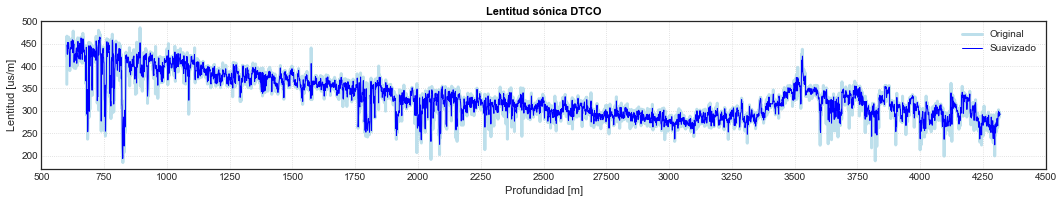

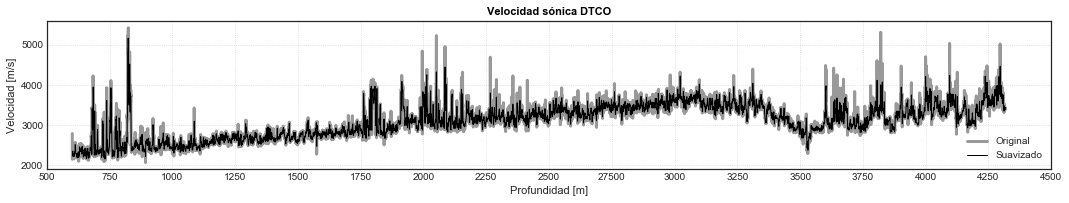

In [8]:
plt.figure(figsize=[18,6])

plt.subplot(2,1,1)
_ = plt.plot(z, dtco, 'lightblue', alpha=0.8, linewidth=3, label = 'Original')
_ = plt.plot(z, dtco_medfilt, 'b', linewidth=1, label = 'Suavizado')
_ = plt.xlim(500, 4500)
_ = plt.xticks(np.linspace(500,4500,17), [500,750,1000,1250,1500,1750,2000,2250,2500,27500,3000,3250,3500,3750,4000,4250,4500])
_ = plt.grid(True, alpha = 0.8, linestyle=':')
_ = plt.legend()
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Lentitud [us/m]', fontsize=11)
_ = plt.title('Lentitud sónica DTCO', fontsize=11, weight = 'semibold', color='black')

plt.figure(figsize=[18,6])

plt.subplot(2,1,1)
_ = plt.plot(z, 1000000/dtco, 'gray', alpha=0.8, linewidth=3, label = 'Original')
_ = plt.plot(z, 1000000/dtco_medfilt, 'k', linewidth=1, label = 'Suavizado')
_ = plt.xlim(500, 4500)
#_ = plt.ylim(2000,3000)
_ = plt.xticks(np.linspace(500,4500,17), [500,750,1000,1250,1500,1750,2000,2250,2500,27500,3000,3250,3500,3750,4000,4250,4500])
_ = plt.grid(True, alpha = 0.8, linestyle=':')
_ = plt.legend()
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Velocidad [m/s]', fontsize=11)
_ = plt.title('Velocidad sónica DTCO', fontsize=11, weight = 'semibold', color='black')


In [9]:
scaled_dt = 0.1525 *np.nan_to_num(dtco_medfilt[3892:])/1e6
tcum = 2 * np.cumsum(scaled_dt)
tdr = tcum + tiempo_lec1 #Curva TZ

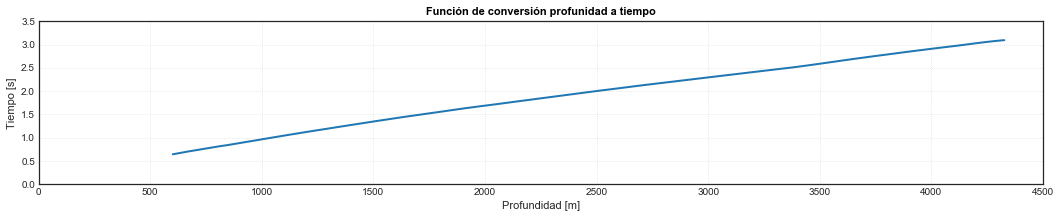

In [10]:
plt.figure(figsize=[18,3])

_ = plt.plot(z[3892:],tdr, lw=2)
_ = plt.xlim(0, 4500)
_ = plt.ylim(0, 3.5)
_ = plt.grid(True, alpha = 0.6, linestyle=':')
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Tiempo [s]', fontsize=11)
_ = plt.title('Función de conversión profunidad a tiempo', fontsize=11, weight = 'semibold', color='black')

In [11]:
dt = 0.00002 #Intervalo de muestreo
maxt = 3.5 #Tiempo máximo
t = np.arange(tiempo_lec1, maxt, dt) #Vector de tiempo 
dtco_t = np.interp(x = t, xp = tdr, fp = dtco_medfilt[3892:])

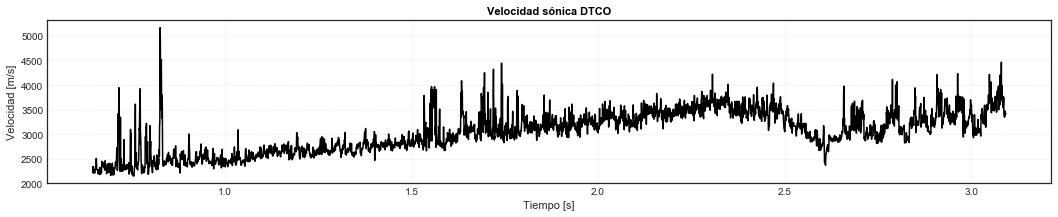

In [12]:
plt.figure(figsize=[18,3])
_ = plt.plot(t,1000000/dtco_t, 'k')
_ = plt.xlabel('Tiempo [s]', fontsize=11)
_ = plt.ylabel('Velocidad [m/s]', fontsize=11)
_ = plt.title('Velocidad sónica DTCO', fontsize=11, weight = 'semibold', color='black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

In [13]:
tops = {}

with open('cimas.txt') as f:
    for line in f.readlines():
        if not line.startswith('#'):
            temp = line.strip().split('\t')
            tops[temp[-1].replace('_',' ')] = float(temp[1])           
tops

{'Cima Arena 4': 3777.0,
 'Base Arena 4': 3836.0,
 'Cima Arena 3': 3895.5,
 'Base Arena 3': 3907.0}

In [14]:
tops.items() , tops.values()

(dict_items([('Cima Arena 4', 3777.0), ('Base Arena 4', 3836.0), ('Cima Arena 3', 3895.5), ('Base Arena 3', 3907.0)]),
 dict_values([3777.0, 3836.0, 3895.5, 3907.0]))

In [15]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

In [16]:
tops_twt = {}

for key, val in tops.items():
    tops_twt[key] = tdr[find_nearest(z[3892:], val)]
    
tops_twt

{'Cima Arena 4': 2.7717606670813959,
 'Base Arena 4': 2.8065862615504709,
 'Cima Arena 3': 2.8454947040274994,
 'Base Arena 3': 2.852145676633703}

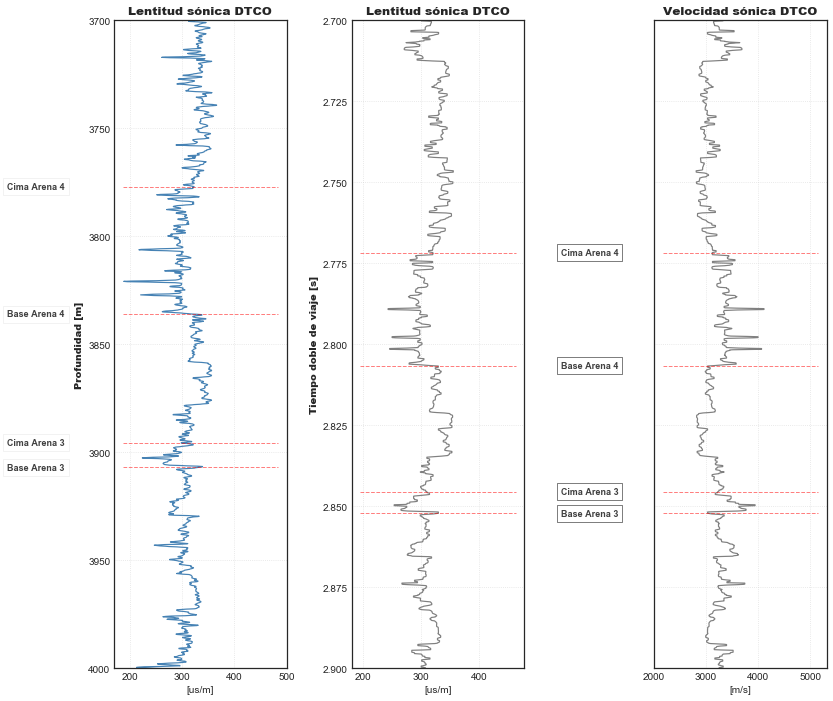

In [17]:
f2 = plt.figure(figsize=[12,10])

ax1 = f2.add_axes([0.05, 0.1, 0.2, 0.9])
ax1.plot(dtco,z,'steelblue', alpha=1, lw=1.2)
ax1.set_title('Lentitud sónica DTCO', style = 'normal', fontsize = 12, weight = 'black')
ax1.set_ylabel('Profundidad [m]', fontsize = 10, weight='black')
ax1.set_xlabel('[us/m]', fontsize = 10)
ax1.set_ylim(3700, 4000)
#ax1.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax1.invert_yaxis()
ax1.grid(True, alpha = 0.6, linestyle=':')

ax2 = f2.add_axes([0.325, 0.1, 0.2, 0.9])
ax2.plot(dtco_t, t,'gray', alpha=1, lw=1.2)
ax2.set_title('Lentitud sónica DTCO', style = 'normal', fontsize = 12, weight = 'black')
ax2.set_ylabel('Tiempo doble de viaje [s]', fontsize = 10, weight= 'black' )
ax2.set_xlabel('[us/m]', fontsize = 10)
ax2.set_ylim(2.70, 2.9)
ax2.invert_yaxis()
ax2.grid(True, alpha = 0.6, linestyle=':')

ax3 = f2.add_axes([0.675, 0.1, 0.2, 0.9])
ax3.plot(1000000/dtco_t, t,'gray', alpha=1, lw=1.2)
ax3.set_title('Velocidad sónica DTCO', style = 'normal', fontsize = 12, weight = 'black')
ax3.set_xlabel('[m/s]', fontsize = 10)
ax3.set_ylim(2.70, 2.9)
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.grid(True, alpha = 0.6, linestyle=':')
     

for i in range(1):
    for top, depth in tops.items():
        f2.axes[i].axhline( y = float(depth), color = 'r', lw = 1, 
                            alpha = 0.5, xmin = 0.05, xmax = 0.95, ls ='--' )
        f2.axes[i].text( x = 20, y = float(depth), s = top,
                         alpha=0.75, color='k',
                         fontsize = 9,
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=0.1, lw = 0.5),
                         weight = 'bold')        
        
for i in range(1,3):
    for twt in tops_twt.values():
        f2.axes[i].axhline( y = float(twt), color = 'r', lw = 1, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95, ls='--')
for i in range(1,2):
    for top, twt in tops_twt.items():
        f2.axes[i].text( x = 590, y = float(twt), s = top,
                         alpha=0.75, color='k',
                         fontsize = 9,
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1, lw = 0.5),
                         weight = 'semibold')

#plt.savefig('Registros.png', transparent=False, dpi=400, bbox_inches='tight')

In [18]:
xline = _read_segy('sfsg_2007xline244.sgy', headonly=True)
seisx = np.stack(t.data for t in xline.traces)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [19]:
horz=pd.read_csv('hor_arena_3.csv')
horz.columns

Index(['inline', 'z_s', 'y', 'z_delta'], dtype='object')

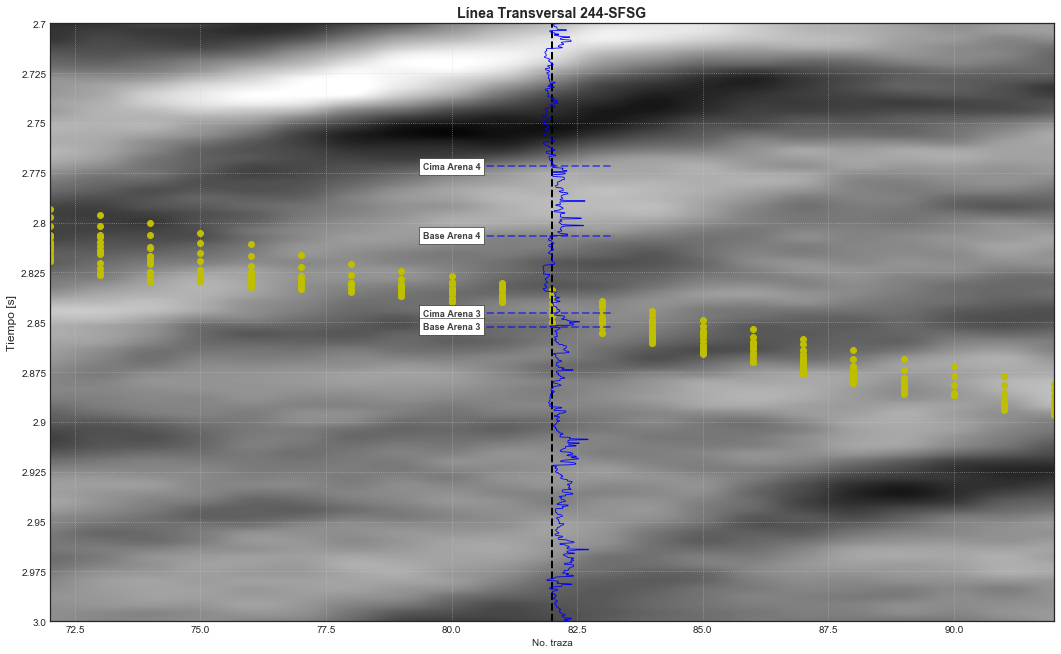

In [20]:
f3 = plt.figure(figsize=[18,11])
gs = gridspec.GridSpec(1,1)
      
ax1 = plt.subplot(gs[0])

percen = np.percentile(seisx,99)
im1 = ax1.imshow(seisx.T[:,:],vmin=-percen, vmax=percen, cmap="binary", aspect='auto', interpolation='gaussian')
ax1.plot(horz['y'],horz['z_delta'],'o',c='y')
ax1.plot([82,82], [0, 800], 'k--', lw=2)  # Posición del pozo Tokal-1
ax1.set_title('Línea Transversal 244-SFSG', fontsize = 14, weight = 'semibold')
ax1.set_xlabel('No. traza', fontsize = 10)
ax1.set_ylabel('Tiempo [s]', fontsize = 12)
plt.xlim(72,92)
plt.ylim(750,675)
plt.yticks(np.linspace(675,750,13),[2.700,2.725,2.750,2.775,2.800,2.825,2.850,2.875,2.900,2.925,2.950,2.975,3.000])
ax1.grid(True, alpha = 0.6, linestyle=':')

base_log = ax1.get_position().get_points()[0][1]
cima_log =  ax1.get_position().get_points()[1][1]

ax2 = ax1.figure.add_axes([0.46, base_log, 0.1, cima_log-base_log])
ax2.plot(1000000/dtco_t, t,'b', alpha=1, lw=0.8)
ax2.set_xlabel('', fontsize = '12')
plt.xlim(1000, 5000)
plt.ylim(2.7,3.0)
ax2.invert_yaxis()
ax2.set_axis_off()
ax2.grid(True, alpha = 0.6, linestyle=':')

for i in range(1,2):
    for twt in tops_twt.values():
        f3.axes[i].axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = -5, xmax = 8, ls='--')
for i in range(1,2):
    for top, twt in tops_twt.items():
        f3.axes[i].text( x = 1, y = float(twt), s = top,
                         alpha=0.75, color='k',
                         fontsize = 9,
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1, lw = 0.5),
                         weight = 'semibold')
        
#plt.savefig('xline244_gray.png', transparent=False, dpi=400, bbox_inches='tight')

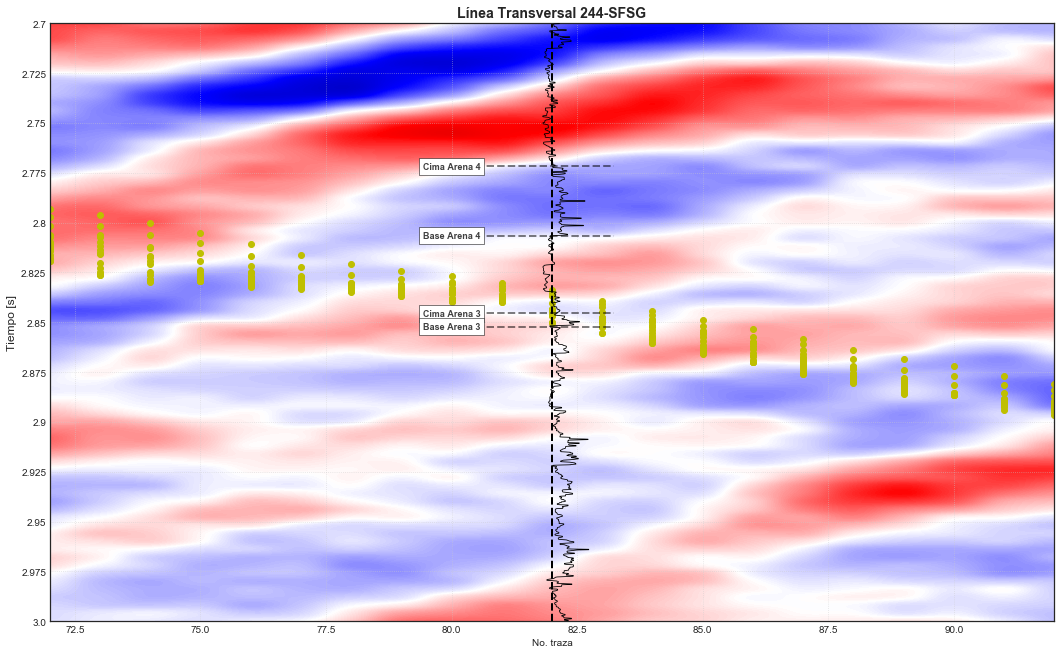

In [21]:
f3 = plt.figure(figsize=[18,11])
gs = gridspec.GridSpec(1,1)
      
ax1 = plt.subplot(gs[0])

percen = np.percentile(seisx,99.8)
im1 = ax1.imshow(seisx.T[:,:],vmin=-percen, vmax=percen, cmap="seismic", aspect='auto', interpolation='gaussian')
ax1.plot(horz['y'],horz['z_delta'],'o',c='y')
ax1.plot([82,82], [0, 800], 'k--', lw=2)  # Posición del pozo Tokal-1
ax1.set_title('Línea Transversal 244-SFSG', fontsize = 14, weight = 'semibold')
ax1.set_xlabel('No. traza', fontsize = 10)
ax1.set_ylabel('Tiempo [s]', fontsize = 12)
plt.xlim(72,92)
plt.ylim(750,675)
plt.yticks(np.linspace(675,750,13),[2.700,2.725,2.750,2.775,2.800,2.825,2.850,2.875,2.900,2.925,2.950,2.975,3.000])
ax1.grid(True, alpha = 0.6, linestyle=':')

base_log = ax1.get_position().get_points()[0][1]
cima_log =  ax1.get_position().get_points()[1][1]

ax2 = ax1.figure.add_axes([0.46, base_log, 0.1, cima_log-base_log])
ax2.plot(1000000/dtco_t, t,'k', alpha=1, lw=0.8)
ax2.set_xlabel('', fontsize = '12')
plt.xlim(1000, 5000)
plt.ylim(2.7,3.0)
ax2.invert_yaxis()
ax2.set_axis_off()
ax2.grid(True, alpha = 0.6, linestyle=':')

for i in range(1,2):
    for twt in tops_twt.values():
        f3.axes[i].axhline( y = float(twt), color = 'k', lw = 2, 
                    alpha = 0.5, xmin = -5, xmax = 8, ls='--')
for i in range(1,2):
    for top, twt in tops_twt.items():
        f3.axes[i].text( x = 1, y = float(twt), s = top,
                         alpha=0.75, color='k',
                         fontsize = 9,
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1, lw = 0.5),
                         weight = 'semibold')
        
#plt.savefig('xline244_seismic.png', transparent=False, dpi=400, bbox_inches='tight')